In [36]:
import numpy as np
import matplotlib.pyplot as plt
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

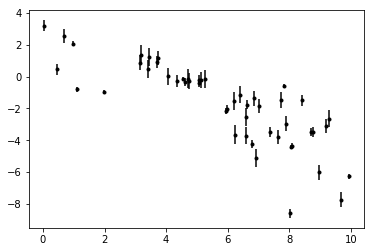

In [37]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.show()

In [38]:
# Least Square Method

A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

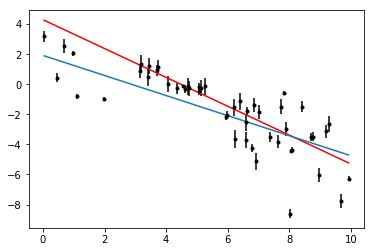

In [39]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.plot(x, m_true*x+b_true, 'r')
plt.plot(x, m_ls*x+b_ls, '-')
plt.show()

In [40]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [43]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(result['x'])

[-0.90463781  3.96788154 -0.48959433]


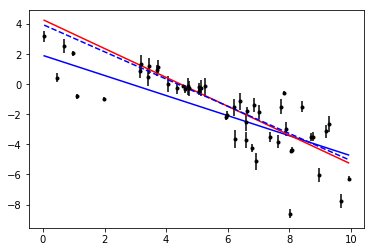

In [42]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.plot(x, m_ls*x+b_ls, 'b-')
plt.plot(x, m_true*x+b_true, 'r')
plt.plot(x, m_ml*x+b_ml, 'b--')
plt.show()

In [53]:
# Flat Prior: the log-prior is (up to a constant)
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [54]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [59]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] # Perturbation, initial position
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
res = sampler.run_mcmc(pos, 500)

In [87]:
samples = sampler.chain[:,-100:,:].reshape((-1,ndim))

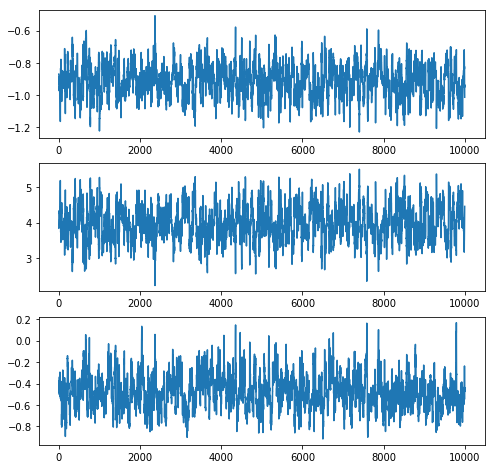

In [89]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((3,1),(0,0))
plt.plot(samples[:,0])
ax2 = plt.subplot2grid((3,1),(1,0))
plt.plot(samples[:,1])
ax3 = plt.subplot2grid((3,1),(2,0))
plt.plot(samples[:,2])
plt.show()

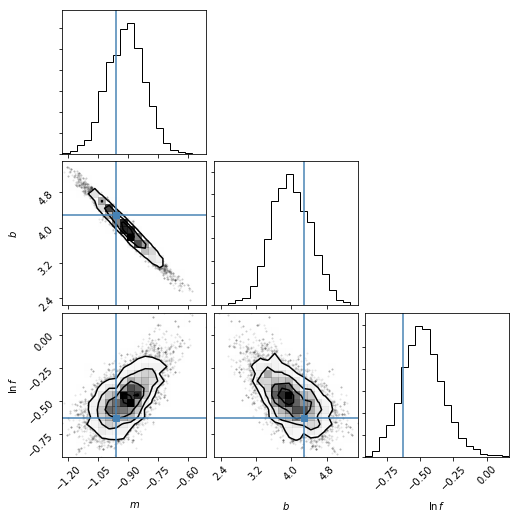

In [91]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])


<ErrorbarContainer object of 3 artists>

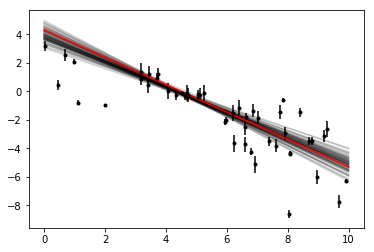

In [92]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)

plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

In [93]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [94]:
print(m_mcmc, b_mcmc, f_mcmc)

(-0.9094152189443763, 0.09073362608502644, 0.0977344998194658) (3.9714784886553467, 0.4708827223669845, 0.42606239067149465) (0.615553078531036, 0.10234117913219032, 0.08107191863387686)


In [101]:
res = np.percentile(samples, [16, 50, 84], axis=0).T
res

array([[-1.00714972, -0.90941522, -0.81868159],
       [ 3.5454161 ,  3.97147849,  4.44236121],
       [ 0.53448116,  0.61555308,  0.71789426]])